Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

Problem: Navier-Stokes Equation

        u*u_x + v*u_y - 1/Re*(u_xx+u_yy) + p_x = 0
        v*v_x + v*v_y - 1/Re*(v_xx+v_yy) + p_y = 0
        u_x + v_y = 0

DNN / PINN   

In [2]:
class PINN(nn.Module):
    global nn_acf
    nn_acf = nn.silu
    
    """PINNs"""
    n_nodes: int    
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]     

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x / 30., y / 15., (x - 7.) / 30., (x - 9.) / 30., (x - 11.) / 30., (y - 2.) / 15., (y + 2.) / 15.])
            # feature mapping
            hidden = self.feats(inputs)
            hidden = jnp.sin(jnp.pi*hidden)
            # hidden = jnp.sin(hidden)

            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)  
    
        u, v, p = get_uvp(x, y)

        def get_uvp_xy(get_uvp, x, y):
            u_x, v_x, p_x = jacfwd(get_uvp)(x, y)
            u_y, v_y, p_y = jacfwd(get_uvp, argnums=1)(x, y)

            return u_x, u_y, v_x, v_y, p_x , p_y
            
        get_uvp_xy_vmap = vmap(get_uvp_xy, in_axes=(None, 0, 0))
        u_x, u_y, v_x, v_y, p_x , p_y = get_uvp_xy_vmap(get_uvp, x, y)
        u_x, u_y, v_x, v_y, p_x , p_y = u_x[:,:,0], u_y[:,:,0], v_x[:,:,0], v_y[:,:,0], p_x[:,:,0] , p_y[:,:,0]

       # obtain u_xx, u_yy, v_xx, v_yy, p_xx, p_yy
        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, p_xx = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, p_yy = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)

            return u_xx, u_yy, v_xx, v_yy, p_xx , p_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy, p_xx , p_yy = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy, p_xx , p_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0], p_xx[:,:,0,0] , p_yy[:,:,0,0]

        # obtain BC indices
        #nbc = (x != x_l) | (x != x_u) | (y != y_l) | (y != y_u)
        bc  = (x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)
        nbc = (~bc)
        uv_bc = (x == x_l) | (y == y_l) | (y == y_u)
        p_bc = (x == x_u)

        # compute PDE residual : N-S equations
        # continuity = u_x + v_y
        # momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        # momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)
        residuals_continuity = u_x + v_y
        residuals_momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
        residuals_momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)
        
        outputs = jnp.hstack([u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, u_y, uv_bc,p_bc, nbc, mom1, mom2])
        return outputs 


class DNN(nn.Module):
    global nn_acf
    nn_acf = nn.silu    
    """DNNs"""
    n_nodes: int
    def setup(self):
        # initialization
        kinit = jax.nn.initializers.he_uniform()
        # feature mapping later
        self.feats = nn.Dense(self.n_nodes * 2, kernel_init = kinit)
        # hidden layers
        self.layers = [nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf]
        # split layers
        self.splitu = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layeru = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitv = nn.Dense(self.n_nodes, kernel_init = kinit)
        self.layerv = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]
        self.splitp = nn.Dense(self.n_nodes, kernel_init = kinit)      
        self.layerp = [nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,
                       nn.Dense(self.n_nodes, kernel_init = kinit),
                       nn_acf,                       
                       nn.Dense(1, kernel_init = kinit, use_bias=False)]    

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_uvp(x, y):
            inputs = jnp.hstack([x / 30., y / 15., (x - 7.) / 30., (x - 9.) / 30., (x - 11.) / 30., (y - 2.) / 15., (y + 2.) / 15.])
            # feature mapping
            hidden = self.feats(inputs)
            # hidden = jnp.sin(hidden)
            hidden = jnp.sin(jnp.pi*hidden)

            # share hidden layer
            for i, lyr in enumerate(self.layers):
                hidden = lyr(hidden)
            # split hidden layer
            u = self.splitu(hidden)
            for i, lyr in enumerate(self.layeru):
                u = lyr(u)  
            v = self.splitv(hidden)
            for i, lyr in enumerate(self.layerv):
                v = lyr(v)   
            p = self.splitp(hidden)
            for i, lyr in enumerate(self.layerp):
                p = lyr(p)
            return (u, v, p)  
            
        u, v, p = get_uvp(x, y)

        def get_uvp_xxyy(get_uvp, x, y):
            u_xx, v_xx, _ = jacfwd(jacfwd(get_uvp))(x, y)
            u_yy, v_yy, _ = jacfwd(jacfwd(get_uvp, argnums=1), argnums=1)(x, y)

            return u_xx, u_yy, v_xx, v_yy
        
        get_uvp_xxyy_vmap = vmap(get_uvp_xxyy, in_axes=(None, 0, 0))
        u_xx, u_yy, v_xx, v_yy, = get_uvp_xxyy_vmap(get_uvp, x, y)
        u_xx, u_yy, v_xx, v_yy = u_xx[:,:,0,0], u_yy[:,:,0,0], v_xx[:,:,0,0], v_yy[:,:,0,0]

        mom1 = -1.0/Re*(u_xx + u_yy)
        mom2 = -1.0/Re*(v_xx + v_yy)

        outputs = jnp.hstack([u, v, p, mom1, mom2])
        return outputs 


In [3]:
def main(ER, ER_xx, weight_bc, batch, max_lr, exponent, max_iter, seed, gpu):

    global Re, x_l, x_u, y_l, y_u
    
    # parameter
    Re = 25
    
    sim = pd.read_csv('FPS_THREE_RE25_1001x501.csv',sep='\\s+')
    sim_x, sim_y, sim_ls = sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1), sim['phi'].values.reshape(-1,1) 
    sim_u, sim_v, sim_p = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1) 
    x_l, x_u, y_l, y_u = np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)
      
    #ext = [x_l, x_u, y_l, y_u]
    #print (x_l, x_u, y_l, y_u)
    
    data_X, data_Y = np.hstack([sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p])
    #print('data_X shape:', data_X.shape, 'data_Y shape:', data_Y.shape)
    
    dx = (np.unique(data_X[:,0])[1] - np.unique(data_X[:,0])[0])
    _inner = (sim_ls[:,0] <= 0.0) | ( abs(sim_ls[:,0] ) <= 0.1*dx)
    data_X, data_Y = data_X[_inner], data_Y[_inner]
    
    square = pd.read_csv('Square.csv',sep='\\s+')
    square_x, square_y = square['x'].values.reshape(-1,1), square['y'].values.reshape(-1,1)    
    data_square_X, data_square_Y = np.hstack([square_x, square_y]), np.zeros((len(square_x), 3))
    
    square2 = pd.read_csv('Square2.csv',sep='\\s+')
    square2_x, square2_y = square2['x'].values.reshape(-1,1), square2['y'].values.reshape(-1,1)    
    data_square2_X, data_square2_Y = np.hstack([square2_x, square2_y]), np.zeros((len(square2_x), 3))
    
    square3 = pd.read_csv('Square3.csv',sep='\\s+')
    square3_x, square3_y = square3['x'].values.reshape(-1,1), square3['y'].values.reshape(-1,1)    
    data_square3_X, data_square3_Y = np.hstack([square3_x, square3_y]), np.zeros((len(square3_x), 3))
        
    l_bc, r_bc = (data_X[:,0] == x_l), (data_X[:,0] == x_u)
    tb_bc = (data_X[:,1] == y_l) | (data_X[:,1] == y_u)
    data_X_l_BC, data_Y_l_BC = data_X[l_bc], data_Y[l_bc]
    data_X_r_BC, data_Y_r_BC = data_X[r_bc], data_Y[r_bc]
    data_X_tb_BC, data_Y_tb_BC = data_X[tb_bc], data_Y[tb_bc]
    data_X_square_BC = np.vstack([data_square_X, data_square2_X, data_square3_X])
    data_Y_square_BC = np.vstack([data_square_Y, data_square2_Y, data_square3_Y])
    
    #print('data_X_l_BC shape:', data_X_l_BC.shape, 'data_Y_l_BC shape:', data_Y_l_BC.shape)
    #print('data_X_r_BC shape:', data_X_r_BC.shape, 'data_Y_r_BC shape:', data_Y_r_BC.shape)
    #print('data_X_tb_BC shape:', data_X_tb_BC.shape, 'data_Y_tb_BC shape:', data_Y_tb_BC.shape)
    #print('data_X_square_BC shape:', data_X_square_BC.shape, 'data_Y_square_BC shape:', data_Y_square_BC.shape)
    
    # convert to jnp
    data_X, data_Y = jnp.array(data_X), jnp.array(data_Y)
    data_X_l_BC, data_Y_l_BC = jnp.array(data_X_l_BC), jnp.array(data_Y_l_BC)
    data_X_r_BC, data_Y_r_BC = jnp.array(data_X_r_BC), jnp.array(data_Y_r_BC)
    data_X_tb_BC, data_Y_tb_BC = jnp.array(data_X_tb_BC), jnp.array(data_Y_tb_BC)
    data_X_square_BC, data_Y_square_BC = jnp.array(data_X_square_BC), jnp.array(data_Y_square_BC)

    BS_ALL = batch
    BS_l_BC, BS_r_BC, BS_tb_BC = int(len(data_X_l_BC)*0.1), int(len(data_X_r_BC)*0.1), int(len(data_X_tb_BC)*0.1)
    BS_square_BC = int(len(data_X_square_BC)*0.2)

    BS_PDE = BS_ALL - BS_l_BC - BS_r_BC - BS_tb_BC - BS_square_BC  #- BS_interpolation # - BS_BC
    n_all, n_l_BC, n_r_BC, n_tb_BC, n_square_BC  = len(data_X), len(data_X_l_BC), len(data_X_r_BC), len(data_X_tb_BC), len(data_X_square_BC)
    print('The total number of samples:', n_all)
    print('BS_ALL:', BS_ALL, ' BS_PDE:',BS_PDE, ' BS_l_BC:',BS_l_BC, ' BS_r_BC:',BS_r_BC, ' BS_tb_BC:',BS_tb_BC, ' BS_square_BC:',BS_square_BC)

    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))
    
    # dummy input
    a = random.normal(key, [1,2])
    
    # initialization call
    n_nodes = 32
    model, model_0 = PINN(n_nodes), DNN(n_nodes)
    params = model.init(key, a) 
    num_params, format_params_fn = get_params_format_fn(params)
    #print (num_params)
    
    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]  
    
    params_0 = params 
    params_interp = params

    @jit
    def minibatch(key):
        key1, key2, key3, key4, key5, key6 = key
        batch_all = random.choice(key1, n_all , (BS_PDE,))
        batch_bc_l = random.choice(key2, n_l_BC, (BS_l_BC,))   
        batch_bc_r = random.choice(key3, n_r_BC, (BS_r_BC,))   
        batch_bc_tb = random.choice(key4, n_tb_BC, (BS_tb_BC,))   
        batch_bc_square = random.choice(key5, n_square_BC, (BS_square_BC,))
        batch_X = jnp.vstack([data_X[batch_all], 
                              data_X_l_BC[batch_bc_l], 
                              data_X_r_BC[batch_bc_r],
                              data_X_tb_BC[batch_bc_tb],
                              data_X_square_BC[batch_bc_square]])
        batch_Y = jnp.vstack([data_Y[batch_all], 
                              data_Y_l_BC[batch_bc_l],
                              data_Y_r_BC[batch_bc_r], 
                              data_Y_tb_BC[batch_bc_tb],
                              data_Y_square_BC[batch_bc_square]])
        return (batch_X, batch_Y)

    def eval_loss(params,params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, u_y, uv_bc, p_bc, nbc, m_1, m_2 = jnp.split(pred, 12, axis=1)
        gt_u, gt_v, gt_p = jnp.split(labels, 3, axis=1)
        x, y = jnp.split(inputs, 2 , axis=1)
        # stable evolution
        pred0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, v_0, p_0, m0_1, m0_2 = jnp.split(pred0, 5, axis=1) 
        # PDE
        residuals_continuity = residuals_continuity + (p - p_0) / ER # ER @PDE
        residuals_momentum_1 = residuals_momentum_1 + (u - u_0) / ER + (m_1 - m0_1) / ER_xx # ER @PDE
        residuals_momentum_2 = residuals_momentum_2 + (v - v_0) / ER + (m_2 - m0_2) / ER_xx # ER @PDE
        pde_uvp  = jnp.square(residuals_continuity) + jnp.square(residuals_momentum_1) + jnp.square(residuals_momentum_2)
        pde_uvp, nbc = pde_uvp[:-BS_square_BC], nbc[:-BS_square_BC]  # remove inner boundary points
        pde_loss = jnp.sum(pde_uvp*nbc) / nbc.sum()
    
        bc_u, bc_v = (u - gt_u), (v - gt_v)
        _tb = (y == y_l) | (y == y_u)
        bc_u = jnp.where(_tb, u_y, bc_u)
        bc_uv = jnp.square(bc_u) + jnp.square(bc_v)
        bc_uv_loss = jnp.sum(bc_uv*uv_bc) / uv_bc.sum()
        
        bc_p = (p)  # p_bc is the mask for p boundary condition
        bc_p_loss =  jnp.sum(jnp.square(bc_p)*p_bc) / p_bc.sum()  # p_bc is the mask for p boundary condition
        
        bc_u_square, bc_v_square = u[-BS_square_BC:], v[-BS_square_BC:] 
        bc_square = jnp.mean(jnp.square(bc_u_square)) + jnp.mean(jnp.square(bc_v_square))  # bc_square is the mask for square boundary condition
        bc_loss = bc_uv_loss + bc_p_loss + bc_square 
        
        loss = pde_loss + bc_loss*weight_bc
        gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
        V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
        mse_u = jnp.mean(jnp.square(u - gt_u)) 
        mse_v = jnp.mean(jnp.square(v - gt_v)) 
        mse_V = jnp.mean(jnp.square(V - gt_V))  # mean squared error of velocity magnitude
        l2_u = jnp.linalg.norm(u - gt_u) / jnp.linalg.norm(gt_u)
        l2_v = jnp.linalg.norm(v - gt_v) / jnp.linalg.norm(gt_v)
        l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
        
        return loss, (mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss)
    
    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))    

    # weights update  
    @jit
    def update(params, params_0,opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss)), grad = loss_grad(params,params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss,mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss

    
    # optimizer
    max_iters = max_iter
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=int(0.0*max_iters),  
                                                      decay_steps=max_iters, end_value=1e-10,exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    # training iteration
    runtime = 0
    train_iters = 0
    
    store = []
    while (train_iters <= max_iters):
        # mini-batch update
        start = time.time()
        key1, key2, key3, key4, key5, key6, rng = random.split(rng, 7) # update random generator
        params, params_0, opt_state, loss, mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss = update(params,params_0, opt_state, (key1, key2,key3,key4,key5,key6))
        end = time.time()
        runtime += (end-start)    
        # append weights
        if (train_iters % 5000 == 0):
            print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse_u = %.2e,  mse_v = %.2e,  rl2_u = %.2e,  rl2_v = %.2e'%(train_iters, runtime, loss, mse_u, mse_v, l2_u, l2_v))
            store.append([train_iters, runtime, loss, mse_u, mse_v, mse_V, l2_u, l2_v, l2_V, pde_loss, bc_loss])
        train_iters += 1
    
    store = jnp.array(store)

    """PINN solution"""
    # solution
    inputs, labels = data_X, data_Y
    uvp = model.apply(format_params_fn(params), inputs)
    u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, uv_bc,p_bc, nbc,res_u,res_v,fx,fy,mom_x_solid,mom_y_solild,res_fx,res_fy = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4], uvp[:,4:5], uvp[:,5:6], uvp[:,6:7], uvp[:,7:8], uvp[:,8:9], uvp[:,9:10], uvp[:,10:11], uvp[:,11:12], uvp[:,12:13], uvp[:,13:14], uvp[:,14:15],uvp[:,15:16],uvp[:,16:17]
    gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
    gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
    V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
    # errors
    mse_V = jnp.mean(jnp.square(V - gt_V)) 
    l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
    print ('[FULLDOM] : mse_V = %.2e, rl2_V = %.2e'%(mse_V, l2_V))

    # inner domain
    _small = (data_X[:,0] <= 14.) & (data_X[:,0] >= 6.) & (data_X[:,1] <= 4.) & (data_X[:,1] >= -4.)
    data_X, data_Y = data_X[_small], data_Y[_small]
    inputs, labels = data_X, data_Y
    uvp = model.apply(format_params_fn(params), inputs)
    u, v, p, residuals_continuity, residuals_momentum_1, residuals_momentum_2, uv_bc,p_bc, nbc,res_u,res_v,fx,fy,mom_x_solid,mom_y_solild,res_fx,res_fy = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3], uvp[:,3:4], uvp[:,4:5], uvp[:,5:6], uvp[:,6:7], uvp[:,7:8], uvp[:,8:9], uvp[:,9:10], uvp[:,10:11], uvp[:,11:12], uvp[:,12:13], uvp[:,13:14], uvp[:,14:15],uvp[:,15:16],uvp[:,16:17]
    gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
    gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
    V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
    # errors
    mse_V = jnp.mean(jnp.square(V - gt_V)) 
    l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
    print ('[COMPACT] : mse_V = %.2e, rl2_V = %.2e'%(mse_V, l2_V))
    
    params_ = format_params_fn(params[:])
    
    return params_, u, v, p


In [4]:
params, u, v, p = main(ER=0.035, ER_xx=15, weight_bc=5, batch=4000,
                       max_lr=5e-3, exponent=1.3, max_iter=80000, seed=40, gpu=0)

The total number of samples: 498236
BS_ALL: 4000  BS_PDE: 3624  BS_l_BC: 50  BS_r_BC: 50  BS_tb_BC: 200  BS_square_BC: 76


2025-08-29 10:07:15.993298: E external/xla/xla/service/hlo_lexer.cc:438] Failed to parse int literal: 894515288310727292233


iter. = 00000,  time = 010s,  loss = 4.48e+00  |  mse_u = 7.38e-01,  mse_v = 2.55e-01,  rl2_u = 8.16e-01,  rl2_v = 6.14e+00
iter. = 05000,  time = 027s,  loss = 1.21e-01  |  mse_u = 2.27e-02,  mse_v = 9.30e-03,  rl2_u = 1.43e-01,  rl2_v = 1.25e+00
iter. = 10000,  time = 044s,  loss = 5.06e-02  |  mse_u = 3.85e-03,  mse_v = 2.10e-03,  rl2_u = 5.88e-02,  rl2_v = 5.96e-01
iter. = 15000,  time = 061s,  loss = 5.87e-02  |  mse_u = 1.04e-03,  mse_v = 2.86e-04,  rl2_u = 3.05e-02,  rl2_v = 2.06e-01
iter. = 20000,  time = 078s,  loss = 1.40e-01  |  mse_u = 8.17e-04,  mse_v = 3.16e-04,  rl2_u = 2.72e-02,  rl2_v = 2.11e-01
iter. = 25000,  time = 095s,  loss = 6.59e-02  |  mse_u = 1.26e-03,  mse_v = 6.26e-04,  rl2_u = 3.36e-02,  rl2_v = 3.11e-01
iter. = 30000,  time = 113s,  loss = 3.74e-02  |  mse_u = 1.53e-03,  mse_v = 4.53e-04,  rl2_u = 3.70e-02,  rl2_v = 2.77e-01
iter. = 35000,  time = 130s,  loss = 3.19e-02  |  mse_u = 1.27e-03,  mse_v = 7.11e-04,  rl2_u = 3.40e-02,  rl2_v = 3.28e-01
iter. = 

Near field

In [17]:
sim = pd.read_csv('FPS_THREE_RE25_1001x501.csv',sep='\\s+')
sim_x, sim_y, sim_ls = sim['x'].values.reshape(-1,1), sim['y'].values.reshape(-1,1), sim['phi'].values.reshape(-1,1) 
sim_u, sim_v, sim_p = sim['u'].values.reshape(-1,1), sim['v'].values.reshape(-1,1), sim['p'].values.reshape(-1,1) 
x_l, x_u, y_l, y_u = np.min(sim_x), np.max(sim_x), np.min(sim_y), np.max(sim_y)

data_X, data_Y = np.hstack([sim_x, sim_y]), np.hstack([sim_u, sim_v, sim_p])

dx = (np.unique(data_X[:,0])[1] - np.unique(data_X[:,0])[0])
_inner = (sim_ls[:,0] <= 0.0) | ( abs(sim_ls[:,0] ) <= 0.1*dx)
data_X, data_Y = data_X[_inner], data_Y[_inner]

_small = (data_X[:,0] <= 20) & (data_X[:,0] >= 6) & (data_X[:,1] <= 4) & (data_X[:,1] >= -4)
data_X, data_Y = data_X[_small], data_Y[_small]
print (data_X.shape, data_Y.shape)

# initialization call
model = DNN(32)

# solution
inputs, labels = data_X, data_Y
uvp = model.apply(params, inputs)
u, v, p= uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]
gt_u, gt_v,gt_p = jnp.split(labels, 3, axis=-1)
gt_V = jnp.sqrt(gt_u**2 + gt_v**2)  # ground truth velocity magnitude
V = jnp.sqrt(u**2 + v**2)  # predicted velocity magnitude
# errors
mse_V = jnp.mean(jnp.square(V - gt_V)) 
l2_V = jnp.linalg.norm(V - gt_V) / jnp.linalg.norm(gt_V)  # relative l2 error of velocity magnitude
print ('[Re=%d] : mse_V = %.2e, rl2_V = %.2e'%(Re, mse_V, l2_V))

(121424, 2) (121424, 3)
[Re=25] : mse_V = 6.66e-05, rl2_V = 9.21e-03


In [20]:
# draw squares
square_xy_center = np.array([[8.0, -2.0], [10.0, 2.0], [12, 0.]])
square_length = 1
half_length = square_length/2

def draw_squares(ax, centers, half_length, color='white'):
    for cx, cy in centers:
        x = [cx - half_length, cx + half_length, cx + half_length, cx - half_length]
        y = [cy - half_length, cy - half_length, cy + half_length, cy + half_length]
        ax.fill(x, y, color=color, edgecolor='black', linewidth=1.0)

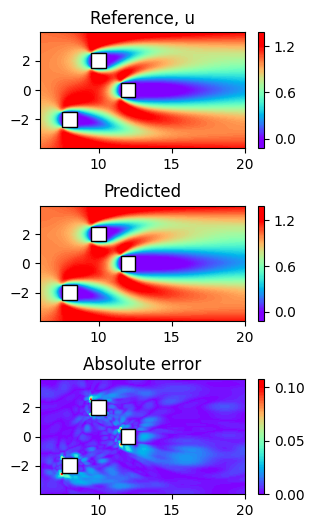

In [44]:
# plot
cfd, pinn = data_Y[:,0], u.flatten()
fig = plt.figure(figsize=(3.5, 6))
fig.subplots_adjust(wspace=.5, hspace=.5)
con_lv = 101
ax1 = fig.add_subplot(3,1,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-0., vmax=1.2);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Reference, u');
plt.colorbar(ticks=[0., 0.6, 1.2]);
ax1 = fig.add_subplot(3,1,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-0., vmax=1.2);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Predicted');
plt.colorbar(ticks=[0., 0.6, 1.2]);
ax1 = fig.add_subplot(3,1,3)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.1);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.05, 0.1]);

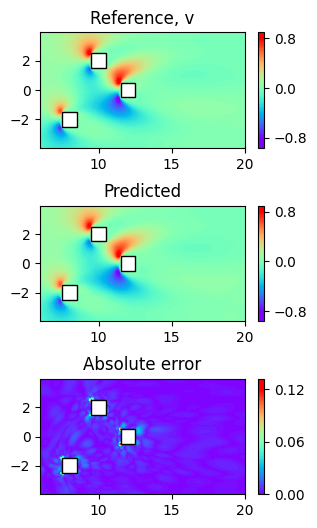

In [43]:
# plot
cfd, pinn = data_Y[:,1], v.flatten()
fig = plt.figure(figsize=(3.5, 6))
fig.subplots_adjust(wspace=.5, hspace=.5)
con_lv = 101
ax1 = fig.add_subplot(3,1,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-.8, vmax=.8);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Reference, v');
plt.colorbar(ticks=[-.8, 0., .8]);
ax1 = fig.add_subplot(3,1,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-.8, vmax=.8);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Predicted');
plt.colorbar(ticks=[-.8, 0., .8]);
ax1 = fig.add_subplot(3,1,3)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.12);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.06, 0.12]);

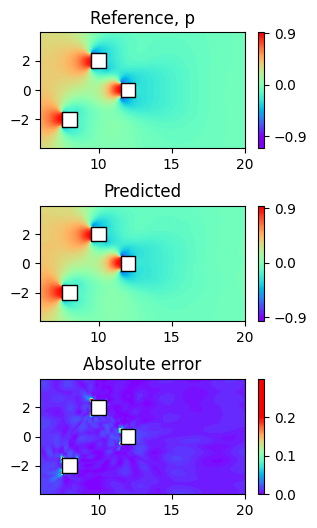

In [49]:
# plot
cfd, pinn = data_Y[:,2], p.flatten()
fig = plt.figure(figsize=(3.5, 6))
fig.subplots_adjust(wspace=.5, hspace=.5)
con_lv = 101
ax1 = fig.add_subplot(3,1,1)
plt.tricontourf(data_X[:,0], data_X[:,1], cfd, con_lv, origin='lower', cmap='rainbow', vmin=-.9, vmax=.9);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Reference, p');
plt.colorbar(ticks=[-.9, 0., .9]);
ax1 = fig.add_subplot(3,1,2)
plt.tricontourf(data_X[:,0], data_X[:,1], pinn, con_lv, origin='lower', cmap='rainbow', vmin=-.9, vmax=.9);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Predicted');
plt.colorbar(ticks=[-.9, 0., .9]);
ax1 = fig.add_subplot(3,1,3)
plt.tricontourf(data_X[:,0], data_X[:,1], abs(cfd - pinn), con_lv, origin='lower', cmap='rainbow', vmin=0, vmax=0.2);
draw_squares(ax1, square_xy_center, half_length); ax1.set_aspect('equal');
plt.xlim(6, 20); plt.ylim(-3.95, 3.95); plt.title('Absolute error');
plt.colorbar(ticks=[0, 0.1, 0.2]);

Near field + streamline

In [14]:
from scipy.interpolate import griddata

square_xy_center = np.array([[8.0, -2.0], [10.0, 2.0], [12, 0.]])
square_length = 1
half_length = square_length/2

def draw_squares(ax, centers, half_length, color='white'):
    for cx, cy in centers:
        x = [cx - half_length, cx + half_length, cx + half_length, cx - half_length]
        y = [cy - half_length, cy - half_length, cy + half_length, cy + half_length]
        ax.fill(x, y, color=color, edgecolor='black', linewidth=1.0)

test_x = np.linspace(6, 20, 500)
test_y = np.linspace(-4, 4, 500)
test_X, test_Y = np.meshgrid(test_x, test_y)
test_inputs = np.hstack([test_X.reshape(-1,1), test_Y.reshape(-1,1)])
test_inputs_jax = jnp.array(test_inputs)

pre_uvp = model.apply(params, test_inputs_jax)
pre_u = np.array(pre_uvp[:, 0]).reshape(test_X.shape)
pre_v = np.array(pre_uvp[:, 1]).reshape(test_X.shape)
pre_V = np.sqrt(pre_u**2 + pre_v**2)
pre_V[pre_V > 1.495] = 0
    
data_u = data_Y[:, 0]
data_v = data_Y[:, 1]
    
cfd_u = griddata(data_X, data_u, test_inputs, method='cubic')
cfd_v = griddata(data_X, data_v, test_inputs, method='cubic')
cfd_u = np.array(cfd_u)
cfd_u[np.isnan(cfd_u)] = 0
cfd_v = np.array(cfd_v)
cfd_v[np.isnan(cfd_v)] = 0
cfd_u = cfd_u.reshape(test_X.shape)
cfd_v = cfd_v.reshape(test_X.shape)
    
CFD_V = np.sqrt(cfd_u**2 + cfd_v**2)
    
vmin = min(np.min(pre_V), np.min(CFD_V))
vmax = max(np.max(pre_V), np.max(CFD_V))
tick_vals = np.linspace(vmin, vmax, 4)
tick_labels = [f'{val:.1f}' for val in tick_vals]

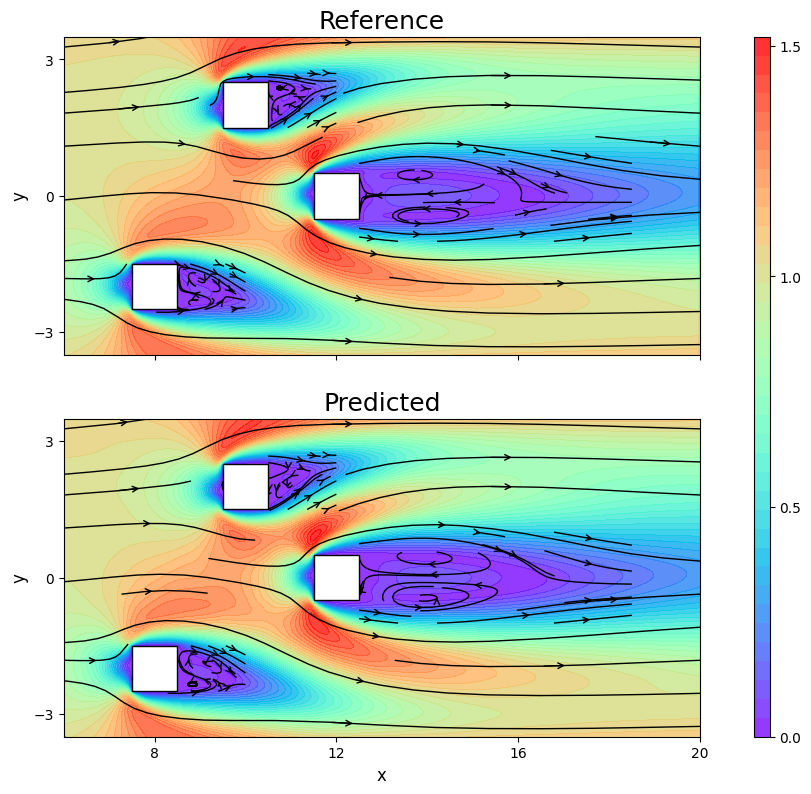

In [16]:
# plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=0.89, top=1, bottom=0, hspace=0.2)
    
cmap = plt.cm.rainbow
norm = plt.Normalize(vmin=vmin, vmax=vmax)

intervals = [(8.5, 10, -2.5, -1.5, 0.2),
             (10.5, 12, 1.5, 2.7, 0.28),
             (12.5, 18.5, -1, 1, 0.28)]
titles = ['Reference', 'Predicted']    
u_list = [cfd_u, pre_u]
v_list = [cfd_v, pre_v]
V_list = [CFD_V, pre_V]

for i in range(2):
    ax = axs[i]
    test_u, test_v, test_V = u_list[i], v_list[i], V_list[i]
    bg = ax.contourf(test_X, test_Y, test_V, levels=40, cmap=cmap, norm=norm, alpha=0.8, zorder=0)
    ax.streamplot(test_x, test_y, test_u, test_v,
                  density=.4, linewidth=1., arrowsize=1.,
                  arrowstyle='->', color='black', zorder=0);
    
    for (x0, x1, y0, y1, d) in intervals:
        x_dense = np.linspace(x0, x1, 50)
        y_dense = np.linspace(y0, y1, 50)
        X_dense, Y_dense = np.meshgrid(x_dense, y_dense)
        inputs_dense = np.hstack([X_dense.reshape(-1, 1), Y_dense.reshape(-1, 1)])
        u_dense = griddata(test_inputs, test_u.flatten(), inputs_dense, method='cubic')
        v_dense = griddata(test_inputs, test_v.flatten(), inputs_dense, method='cubic')
        u_dense[np.isnan(u_dense)] = 0
        v_dense[np.isnan(v_dense)] = 0
        u_dense = u_dense.reshape(X_dense.shape)
        v_dense = v_dense.reshape(X_dense.shape)
        ax.streamplot(x_dense, y_dense, u_dense, v_dense,
                      density=d, linewidth=1., arrowsize=1,
                      arrowstyle='->', color='black', zorder=0)
    
    draw_squares(ax, square_xy_center, half_length)
    ax.set_ylim(-3.5, 3.5); ax.set_xlim(6, 20);
    ax.set_xticks(np.linspace(8, 20, 4)); ax.set_yticks(np.linspace(-3, 3, 3));
    ax.set_title(titles[i], fontsize=18)
    ax.set_aspect('equal')

# label
axs[1].set_xlabel('x', fontsize=12)
axs[1].set_ylabel('y', fontsize=12)
axs[0].set_ylabel('y', fontsize=12)

# colorbar
cbar_ax = fig.add_axes([0.91, 0., 0.02, 1.]); # [left, bottom, width, height]
cbar = fig.colorbar(bg, cax=cbar_ax, ticks=tick_vals);
cbar.ax.set_yticklabels(tick_labels);
cbar.ax.tick_params(labelsize=10);